In [4]:
import sys
sys.path.append("../drift-detection")
from shift_detector import *
from shift_reductor import *
from shift_experiments import *
from shift_tester import *
import pandas as pd
import os
from shift_utils import *
from shift_constants import *
from shift_plot_utils import *
from alibi_detect.cd import ChiSquareDrift, TabularDrift
import matplotlib as mpl
import matplotlib.pyplot as plt

### Load data ###

In [16]:
(X_tr, y_tr), (X_val, y_val), (X_t, y_t), orig_dims = import_dataset('los',shuffle=True,)
(X_t_1, y_t_1) = apply_shift(X_tr, y_tr, X_t, y_t, 'small_gn_shift_0.1')

### Plot ###

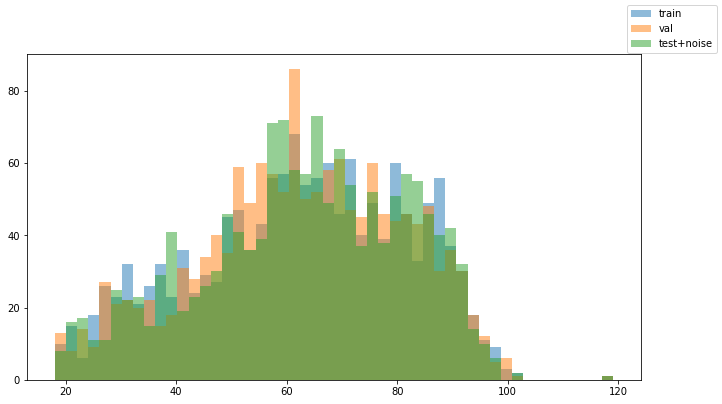

In [22]:
fig, ax = plt.subplots(figsize=(11, 6))
plt.hist(X_tr[:,0], bins=50, alpha=0.5,label='train')
plt.hist(X_val[:,0], bins=50, alpha=0.5, label='val')
plt.hist(X_t_1[:,0], bins=50, alpha=0.5 , label='test+noise')
fig.legend(loc='upper right')
plt.show()

### KS Test ###

In [23]:
test_hosp='UHNTG'
train_hosp='SMH'
(X_tr, y_tr), (X_val, y_val), (X_t, y_t), orig_dims = import_dataset_hospital('los',[HOSPITAL_ID[train_hosp]],[HOSPITAL_ID[test_hosp]])
sample = X_val.shape[0]
cd = TabularDrift(X_val, p_val=.05)
preds = cd.predict(X_t[0:sample,])
labels = ['No!', 'Yes!']
import scipy.stats as ss
pvals = preds['data']['p_val']
feat_rank = ss.rankdata(pvals)
for i in range(0,len(pvals)):
    i = int(i)
    if i == 3:
        break
    n = i+1
    feat_index = np.where(feat_rank == n)[0][0]
    print('{} Drift? {} P-value: {}'.format(features[feat_index],labels[preds['data']['is_drift']],pvals[feat_index]))


sex Drift? Yes! P-value: 1.3406529433268588e-06
icd10_C00_D49 Drift? Yes! P-value: 0.00627606688067317
age Drift? Yes! P-value: 0.026416651904582977



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


In [ ]:
label = 'los'
feat_index = np.where(feat_rank == 1)[0][0]
fig, ax = plt.subplots(figsize=(11, 6))
if features[feat_index] == "age":
    plt.hist(X_tr[:,feat_index], bins=50, alpha=0.5,label=train_hosp)
    plt.hist(X_val[:,feat_index], bins=50, alpha=0.5, label=train_hosp)
    plt.hist(X_t[0:sample,feat_index], bins=50, alpha=0.5 , label=test_hosp)
else:
    #fig.add_axes([0,1])
    X_tr = pd.concat([pd.DataFrame(X_tr,columns=features),pd.DataFrame(y_tr,columns=['los'])],axis=1)
    X_tr_pos = X_tr.loc[X_tr[label] == 1]
    plt.bar([0,1],np.bincount(X_tr[features[feat_index]]),color='g')
    plt.bar([0,1],np.bincount(X_tr_pos[features[feat_index]]),color='r')
  #  X_val_pos = X_val.loc[X_val[label] == 1]
  #  plt.bar([0,1],np.bincount(X_val[:,feat_index]))
    X_t = pd.concat([pd.DataFrame(X_t,columns=features),pd.DataFrame(y_t,columns=['los'])],axis=1)
    X_t_pos = X_t.loc[X_t[label] == 1]  
    plt.bar([0,1]+0.25,np.bincount(X_t[:,feat_index]),color='g')
    plt.bar([0,1]+0.25,np.bincount(X_t_pos[:,feat_index]),color='r')
    #'LOS ',"LOS > 7 days"
fig.legend(loc='upper right')
plt.show()

### MMD ###

In [11]:
#preprocess_fn = partial(preprocess_drift, model=encoder_net, device=device, batch_size=512)
cd = MMDDrift(X_val, backend='pytorch', p_val=.05,)
preds = cd.predict(X_t_1)
print('Drift? {} P-value: {}'.format(labels[preds['data']['is_drift']],preds['data']['p_val']))

No GPU detected, fall back on CPU.
Drift? Yes! P-value: 0.009999999776482582


### All Multivariate ###

In [6]:
path = "/path/"
dataset = "gemini"
samples = [10, 50, 100, 500, 1000]
# Number of random runs to average results over.
random_runs = 5
# Significance level.
sign_level = 0.05
# Whether to calculate accuracy for malignancy quantification.
calc_acc = True
# Define shift types.
shifts = ['medium_gn_shift_0.1','medium_gn_shift_0.5','medium_gn_shift_1.0']

dr_technique = "NoRed"
md_tests = ["MMD","LK","LSDD"]
mean_shifts_pca_md = np.ones((len(shifts),len(md_tests),len(samples))) * (-1)
std_shifts_pca_md = np.ones((len(shifts),len(md_tests),len(samples))) * (-1)

for si, shift in enumerate(shifts):
    for mi, md_test in enumerate(md_tests):                
        mean_p_vals, std_p_vals = run_synthetic_shift_experiment(shift, path, dr_technique, md_test, samples, dataset,sign_level,["age"],random_runs=5,calc_acc=True)
        mean_shifts_pca_md[si,mi,:] = mean_p_vals
        std_shifts_pca_md[si,mi,:] = std_p_vals   

Shift medium_gn_shift_0.1


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.949999988079071
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.46000000834465027
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 2 : Sample 10
No GPU detected, 

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.5
Random Run 0 : Sample 50
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.9900000095367432
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.4000000059604645
Random Run 0 : Sample 1000
Shift p-vals:  0.49000000953674316


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  1.0
Random Run 1 : Sample 50
Shift p-vals:  0.9900000095367432
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.05000000074505806
Random Run 1 : Sample 1000
Shift p-vals:  0.07999999821186066


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.20999999344348907
Random Run 2 : Sample 50
Shift p-vals:  0.6700000166893005
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.5199999809265137
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.28999999165534973
Random Run 2 : Sample 1000
Shift p-vals:  0.23000000417232513


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.009999999776482582
Random Run 3 : Sample 50
Shift p-vals:  0.05000000074505806
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.4000000059604645
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  1.0
Random Run 3 : Sample 1000
Shift p-vals:  0.8500000238418579


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.029999999329447746
Random Run 4 : Sample 50
Shift p-vals:  0.8299999833106995
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.5099999904632568
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.4699999988079071
Random Run 4 : Sample 1000
Shift p-vals:  0.5600000023841858
Shift medium_gn_shift_0.1


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.46000000834465027
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 2 : Sample 10
No GPU detected, f

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6600000262260437
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 2 : Sample 10
No GPU detected, f

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 50
Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.20999999344348907
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.4699999988079071
Random Run 0 : Sample 1000
Shift p-vals:  0.5


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.05999999865889549
Random Run 1 : Sample 50
Shift p-vals:  0.7300000190734863
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.10000000149011612
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.8199999928474426
Random Run 1 : Sample 1000
Shift p-vals:  0.38999998569488525


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.5
Random Run 2 : Sample 50
Shift p-vals:  0.7300000190734863
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.8500000238418579
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.18000000715255737
Random Run 2 : Sample 1000
Shift p-vals:  0.07999999821186066


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.05000000074505806
Random Run 3 : Sample 50
Shift p-vals:  0.27000001072883606
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.4000000059604645
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.7200000286102295
Random Run 3 : Sample 1000
Shift p-vals:  0.6399999856948853


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.05000000074505806
Random Run 4 : Sample 50
Shift p-vals:  0.14000000059604645
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.7400000095367432
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.5799999833106995
Random Run 4 : Sample 1000
Shift p-vals:  0.23999999463558197
Shift medium_gn_shift_0.5


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.699999988079071
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shi

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.28999999165534973
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Sh

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 50
Shift p-vals:  0.4099999964237213
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.6899999976158142
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.550000011920929
Random Run 0 : Sample 1000
Shift p-vals:  0.8299999833106995


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 50
Shift p-vals:  0.4399999976158142
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.3400000035762787
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.9300000071525574
Random Run 1 : Sample 1000
Shift p-vals:  0.800000011920929


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.18000000715255737
Random Run 2 : Sample 50
Shift p-vals:  0.17000000178813934
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.03999999910593033
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.14000000059604645
Random Run 2 : Sample 1000
Shift p-vals:  0.9399999976158142


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.27000001072883606
Random Run 3 : Sample 50
Shift p-vals:  0.5799999833106995
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.12999999523162842
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 3 : Sample 1000
Shift p-vals:  0.25999999046325684


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.03999999910593033
Random Run 4 : Sample 50
Shift p-vals:  0.0
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.8999999761581421
Random Run 4 : Sample 1000
Shift p-vals:  0.4300000071525574
Shift medium_gn_shift_1.0


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3100000023841858
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.30000001192092896
Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.20

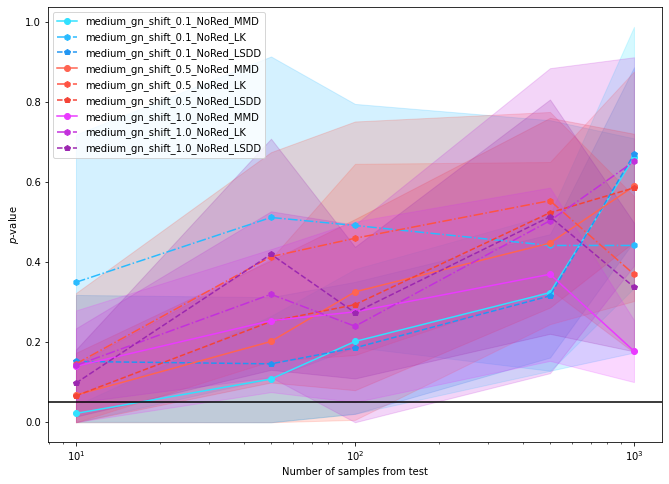

In [7]:
fig = plt.figure(figsize =(11, 8))
for si, shift in enumerate(shifts):
    for mi, md_test in enumerate(md_tests):
        errorfill(np.array(samples), mean_shifts_pca_md[si,mi,:], std_shifts_pca_md[si,mi,:], fmt=linestyles[mi]+markers[mi], color=colorscale(colors[si],brightness[mi]), label="%s" % '_'.join([shift,dr_technique,md_test]))
plt.xlabel('Number of samples from test')
plt.ylabel('$p$-value')
plt.axhline(y=sign_level, color='k')
plt.legend()
plt.show()